## Intent Classification With PyTorch
Previously, my focus in the notebooks was on obtaining labeled data for my chatbot. However, this current notebook is centered around utilizing PyTorch for the classification of intents within fresh, unseen user-generated data. The model has transitioned to a supervised learning approach, leveraging the labels derived from the unsupervised learning conducted in the preceding notebook.

### RASA Comparison

Rasa trains this intent classification step with SVM and GridsearchCV because they can try different configurations ([source](https://medium.com/bhavaniravi/intent-classification-demystifying-rasanlu-part-4-685fc02f5c1d)). When deploying preprocessing pipeline should remain same between train and test.

In [42]:
!pip3 install wandb


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip3 install --upgrade pip


In [75]:
%pip install fasttext-langdetect

  Using cached fasttext-langdetect-1.0.5.tar.gz (6.8 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 1.2 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.1-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.1-py3-none-any.whl (238 kB)
  Created wheel for fasttext-langdetect: filename=fasttext_langdetect-1.0.5-py3-none-any.whl size=7503 sha256=8453bc8e4db4965ecb10b58a6cb9410e60739e3475daff3820aaa2cb9cb0c5c6
  Stored in directory: /Users/saggysimmba/Library/Caches/pip/wheels/02/98/3e/91a2527cd5ff03e889b6089faf95681f8cc6310eb72a0c636a
  Created wheel for fasttext: filename=fasttext-0.9.3-cp312-cp312-macosx_14_0_universal2.whl size=623348 sha256=371ce65bfa348b6e93f752bea8e314e5a5e3fd7a40d06ae1

In [1]:
import spacy 
import wandb
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
nlp = English()

# Create a blank Tokenizer with just the English vocab
tokenizer = Tokenizer(nlp.vocab)

In [2]:
# Standard 
import collections
import yaml
import re
import os

# Data science
import pandas as pd
print(f"Pandas: {pd.__version__}")
import numpy as np
print(f"Numpy: {np.__version__}")

# Machine Learning
import sklearn
print(f"Sklearn: {sklearn.__version__}")

# Deep Learning
import torch
from torch import nn
import torch.optim as optim

# Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

# Preprocessing and Torch
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
# from torchtext.data.utils import get_tokenizer
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.utils.data import Dataset, DataLoader, TensorDataset
# from torchtext.vocab import build_vocab_from_iterator
# from torchtext.data import get_tokenizer

# Warnings 
import warnings 
warnings.filterwarnings('ignore')

# Reading in training data
train = pd.read_pickle('../objects/train.pkl')
print(f'Training data: {train.head()}')

Pandas: 2.2.2
Numpy: 1.26.4
Sklearn: 1.4.2
Training data:                                              support  \
0  [very, poor, feedback, very, disappointing, se...   
1  [already, done, i, am, frankly, fed, up, with,...   
2  [very, poor, feedback, very, disappointing, se...   
3  [can, see, you, have, replied, to, others, who...   
4  [my, issue, is, not, resolved, really, should,...   

                                         account           greeting  \
0                      [email, account, details]    [good, morning]   
1                      [email, account, details]  [good, afternoon]   
2                      [email, account, details]    [good, evening]   
3  [the, credit, card, information, is, correct]      [good, night]   
4                        [account, email, email]        [good, day]   

            goodbye     speak_representative            challenge_robot  \
0         [goodbye]    [talk, human, please]            [are, you, bot]   
1      [thank, you]     [let

In [4]:
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
Aborted!


In [3]:
# Configuration for training
# Change all of the following configurations as per the specifications in the original repo 
# Set a seed value 
seed_value = 12321 

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `pytorch` pseudo-random generator at a fixed value
torch.manual_seed(seed_value)

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [59]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="intent-classification",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "epochs": 30,
    "batch_size": 32, 
    "embedding_size": 200,
    "hidden_size": 128,
    "output_size": 9,
    "num_layers": 2,
    "dropout": 0.2,
    "eval_metric": "accuracy", 
    "weight_decay": 1e-6,
    "scheduler_lambda_epoch_threshold": 10,
    "scheduler_decay_rate": -0.1
    }
)

Training Accuracy,▁▇▇███
Training Loss,█▂▂▁▁▁
Validation Accuracy,▁▆▇███
Validation F1 Score,▁▆████
Validation Loss,█▄▂▂▁▁
epoch,▁▂▄▅▇█
Training Accuracy,84.63763
Training Loss,4212.7321
Validation Accuracy,82.76762
Validation F1 Score,0.82519
Validation Loss,1190.43005


In [6]:
train = pd.melt(train)
train.columns = ["intent", "tokens"]

In [7]:
shuffled_df = train.sample(frac=1).reset_index(drop=True)
shuffled_df 

,intent,tokens
0,challenge_robot,"[is, this, computer, program]"
1,discount,"[do, you, ve, plans, to, bring, this, item, in..."
2,quality,"[defective, item, replacement, process, details]"
3,speak_representative,"[talk, support, agent]"
4,discount,"[discounted, price, discount]"
...,...,...
13495,support,"[in, english, it, may, be, called, something, ..."
13496,goodbye,"[thanks, so, much, see, you]"
13497,goodbye,"[appreciate, that]"
13498,speak_representative,"[let, talk, support]"


In [8]:
train["tokens"]

0        [very, poor, feedback, very, disappointing, se...
1        [already, done, i, am, frankly, fed, up, with,...
2        [very, poor, feedback, very, disappointing, se...
3        [can, see, you, have, replied, to, others, who...
4        [my, issue, is, not, resolved, really, should,...
                               ...                        
13495    [please, unblock, my, account, i, need, to, pu...
13496    [i, know, that, amazon, did, not, manufacture,...
13497    [friend, do, not, use, amazon, pay, its, not, ...
13498                                              [india]
13499    [can, you, see, which, type, of, service, the,...
Name: tokens, Length: 13500, dtype: object

In [9]:
train["tokens"][0]

['very', 'poor', 'feedback', 'very', 'disappointing', 'services']

In [10]:
import ast
import string 

In [11]:
# List of common stopwords
manual_stopwords = {
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 
    'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 
    'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 
    'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 
    'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 
    'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 
    'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 
    'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 
    'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 
    'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 
    'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now'
}



def basic_preprocess_tokens(tokens):
    
    # Convert string representation of list to actual list
    # tokens = ast.literal_eval(tokens)
    
    # Convert to lowercase
    tokens = [token.lower() for token in tokens]
    
    # Remove punctuation
    tokens = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]
    
    # Remove stopwords
    tokens = [token for token in tokens if token not in manual_stopwords]
    
    return tokens

# Apply basic preprocessing to the tokens column
shuffled_df['cleaned_tokens'] = shuffled_df['tokens'].apply(basic_preprocess_tokens)

shuffled_df.head()


,intent,tokens,cleaned_tokens
0,challenge_robot,"[is, this, computer, program]","[computer, program]"
1,discount,"[do, you, ve, plans, to, bring, this, item, in...","[ve, plans, bring, item, prime, trust, sellers]"
2,quality,"[defective, item, replacement, process, details]","[defective, item, replacement, process, details]"
3,speak_representative,"[talk, support, agent]","[talk, support, agent]"
4,discount,"[discounted, price, discount]","[discounted, price, discount]"


In [12]:
# Wherever the length of the tokens is 0, we will remove those rows
shuffled_df = shuffled_df[shuffled_df['cleaned_tokens'].apply(len) > 0]
shuffled_df.shape

(13402, 3)

In [13]:
shuffled_df["intent"].value_counts()

intent
challenge_robot         1500
speak_representative    1500
goodbye                 1500
track                   1500
discount                1499
account                 1495
support                 1494
quality                 1489
greeting                1425
Name: count, dtype: int64

<Axes: ylabel='Count'>

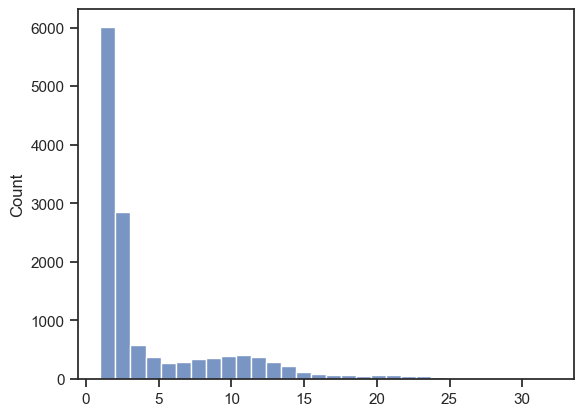

In [14]:
seq_lens = [len(tokens) for tokens in shuffled_df['cleaned_tokens']]
sns.histplot(seq_lens, bins=30)

In [15]:
shuffled_df.to_csv("../data/processed/train_intents.csv", index=False)

In [16]:
# Print the data types of the columns
print(shuffled_df.dtypes)

# Check the data types of each row in the "tokens" column and if its not a list, highlight the the error 
# Don't print it, log it 
print(" ")
for index, row in shuffled_df.iterrows():
    if not isinstance(row["tokens"], list):
        print(f"Error: {row['tokens']}")

intent            object
tokens            object
cleaned_tokens    object
dtype: object
 


In [17]:
X = [token_lst for token_lst in shuffled_df['cleaned_tokens']]
X = [*X]
y = [*shuffled_df['intent'].values]

In [18]:
import nltk 
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saggysimmba/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/saggysimmba/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Torchtext Preprocessing

### Torchtext tokenizer 
- Add description later 

### Plan of Action
- Prepare the dataset 

In [22]:
%pwd

'/Applications/saggydev/projects_learning/amazon_support/notebooks'

- Steps taken
    -   the words would involve creating a vocabulary dictionary to map words to indices 
    -   For each sequence, the words are converted into their corresponding indices based on the word dictionary 
    - When feeding sentences into the model, ensure a consistent sequence length is crucial 
    - To achieve this, sequences are padded with zeros until they reach the length of the longest sequence 
    - This padding ensures uniformity, and shorter maximum lengths are typically preferred for ease of training, as longer sequences can pose challenges 
    - This padding ensures uniformity, and shorter maximum lengths are typically preferred for ease of training, as longer sequences can pose challenges 


In [19]:
# Use glove word embeddings 
embeddings_index = {}
f = open("../models/glove.twitter.27B/glove.twitter.27B.200d.txt", "r", encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [60]:
# Now build a vocabulary: This is something I hadve just added 
from collections import Counter
word_counts = Counter(token for sentence in X for token in sentence)
vocabulary = {word: i+1 for i, (word, _) in enumerate(word_counts.items())}  # Reserve 0 for padding 
vocabulary["<unknown>"] = len(vocabulary) + 1  # Reserve for unknown words

In [21]:
embeddings_index["<unknown>"]

array([-0.20198  ,  0.41916  , -1.0054   , -0.84391  , -0.68951  ,
        0.18279  , -0.23453  , -0.0052121,  0.45239  , -0.92015  ,
       -0.13365  ,  0.040719 ,  0.072168 , -0.062865 , -1.3087   ,
        0.27299  ,  0.52128  ,  0.57118  ,  0.29222  ,  0.33075  ,
       -0.24459  , -0.37486  ,  1.1441   , -0.46274  , -0.076162 ,
        0.82587  , -0.24807  , -0.944    ,  0.61853  , -0.39438  ,
        0.59014  , -0.29744  , -0.35508  ,  0.53303  ,  0.44923  ,
       -0.63778  , -0.15895  , -0.86348  , -0.49895  , -0.041426 ,
        0.43123  ,  0.29367  , -1.2033   , -0.45566  , -0.34636  ,
       -0.02048  , -1.7236   ,  0.5066   , -0.81875  , -0.21657  ,
       -0.26766  ,  0.35248  ,  0.078784 , -0.66945  ,  1.1626   ,
        0.0051163, -1.0655   ,  0.096867 ,  0.33572  ,  0.52233  ,
        0.40273  ,  0.027763 , -0.58058  , -0.42969  , -0.22255  ,
        0.51217  ,  0.011956 ,  0.043467 ,  0.3244   ,  1.0959   ,
        0.11997  ,  0.60929  ,  0.068    ,  0.19848  , -0.4623

In [22]:
embeddings_index.get("<unknown>")

array([-0.20198  ,  0.41916  , -1.0054   , -0.84391  , -0.68951  ,
        0.18279  , -0.23453  , -0.0052121,  0.45239  , -0.92015  ,
       -0.13365  ,  0.040719 ,  0.072168 , -0.062865 , -1.3087   ,
        0.27299  ,  0.52128  ,  0.57118  ,  0.29222  ,  0.33075  ,
       -0.24459  , -0.37486  ,  1.1441   , -0.46274  , -0.076162 ,
        0.82587  , -0.24807  , -0.944    ,  0.61853  , -0.39438  ,
        0.59014  , -0.29744  , -0.35508  ,  0.53303  ,  0.44923  ,
       -0.63778  , -0.15895  , -0.86348  , -0.49895  , -0.041426 ,
        0.43123  ,  0.29367  , -1.2033   , -0.45566  , -0.34636  ,
       -0.02048  , -1.7236   ,  0.5066   , -0.81875  , -0.21657  ,
       -0.26766  ,  0.35248  ,  0.078784 , -0.66945  ,  1.1626   ,
        0.0051163, -1.0655   ,  0.096867 ,  0.33572  ,  0.52233  ,
        0.40273  ,  0.027763 , -0.58058  , -0.42969  , -0.22255  ,
        0.51217  ,  0.011956 ,  0.043467 ,  0.3244   ,  1.0959   ,
        0.11997  ,  0.60929  ,  0.068    ,  0.19848  , -0.4623

In [23]:
vocabulary.items()

dict_items([('computer', 1), ('program', 2), ('ve', 3), ('plans', 4), ('bring', 5), ('item', 6), ('prime', 7), ('trust', 8), ('sellers', 9), ('defective', 10), ('replacement', 11), ('process', 12), ('details', 13), ('talk', 14), ('support', 15), ('agent', 16), ('discounted', 17), ('price', 18), ('discount', 19), ('im', 20), ('done', 21), ('see', 22), ('given', 23), ('options', 24), ('track', 25), ('order', 26), ('info', 27), ('available', 28), ('emailed', 29), ('customer', 30), ('service', 31), ('contact', 32), ('number', 33), ('thanks', 34), ('sorry', 35), ('hassle', 36), ('virtual', 37), ('assistant', 38), ('find', 39), ('shipping', 40), ('speak', 41), ('someone', 42), ('fall', 43), ('sale', 44), ('information', 45), ('apply', 46), ('uk', 47), ('residents', 48), ('hello', 49), ('everybody', 50), ('link', 51), ('anything', 52), ('message', 53), ('sent', 54), ('know', 55), ('minor', 56), ('thing', 57), ('opt', 58), ('general', 59), ('account', 60), ('hard', 61), ('remember', 62), ('smi

In [24]:
# Create an embedding matrix
embedding_dim = 200
vocab_size = len(vocabulary) + 1  # +1 for unknown token 

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in vocabulary.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        # Assign the chosen unknown vector representation
        embedding_matrix[i] = embeddings_index.get("<unknown>")

In [25]:
# Encocde sentences as sequences of integers: This is something I have just added
def encode_sequences(tokenized_sentences, vocab):
    sequences = []
    for sentence in tokenized_sentences:
        sequence = [vocab.get(word, "<unknown>") for word in sentence]  # 0 for unknown words
        sequences.append(sequence)
    return sequences

In [26]:
X_seq = encode_sequences(X, vocabulary)

In [27]:
from sklearn.model_selection import train_test_split

# Label encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split dataset into stratified train and test sets
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_encoded, test_size=0.2, shuffle=True, random_state=seed_value)

In [28]:
# Label encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert the target variable to a tensor
X_train_tensors = [torch.tensor(sequence, dtype=torch.long) for sequence in X_train]
X_val_tensors = [torch.tensor(sequence, dtype=torch.long) for sequence in X_val]

# Pad the sequences
X_train_tensor = pad_sequence(X_train_tensors, batch_first=True)
X_val_tensor = pad_sequence(X_val_tensors, batch_first=True)

In [29]:
X_train_tensor.shape, X_val_tensor.shape

(torch.Size([10721, 31]), torch.Size([2681, 32]))

In [30]:
seq_len = 32

In [31]:
def re_pad_sequences(tensor, fixed_length):
    # Calculate the difference in length
    length_diff = fixed_length - tensor.shape[1]
    
    if length_diff > 0:
        # If the tensor is shorter, pad it
        padding = torch.zeros((tensor.shape[0], length_diff), dtype=tensor.dtype)
        padded_tensor = torch.cat([tensor, padding], dim=1)
    elif length_diff < 0:
        # If the tensor is longer, truncate it
        padded_tensor = tensor[:, :fixed_length]
    else:
        # If the tensor is already at the desired length, do nothing
        padded_tensor = tensor
    
    return padded_tensor

In [32]:
X_train_tensor = re_pad_sequences(X_train_tensor, 32)
X_val_tensor = re_pad_sequences(X_val_tensor, 32)

In [33]:
y_train_tensor = torch.tensor(y_train)
y_val_tensor = torch.tensor(y_val)

In [34]:
X_train_tensor.dtype

torch.int64

In [35]:
y_train_tensor.dtype

torch.int64

In [136]:
# from torch import LongTensor
# train_seq_lengths = LongTensor(list(map(len, X_train_tensors)))
# val_seq_lengths = LongTensor(list(map(len, X_val_tensors)))

In [137]:
# Sort sequences by lengths in descending order (if not already sorted)
# X_train_sorted, train_lengths_sorted = X_train_tensor[train_seq_lengths.sort(descending=True)[1]], train_seq_lengths[train_seq_lengths.sort(descending=True)[1]]
# X_val_sorted, val_lengths_sorted = X_val_tensor[val_seq_lengths.sort(descending=True)[1]], val_seq_lengths[val_seq_lengths.sort(descending=True)[1]]

In [160]:
# Assuming y_train and y_val are your target tensors

# Get sorting indices for train and validation sequences
# train_sort_indices = train_seq_lengths.sort(descending=True)[1]
# val_sort_indices = val_seq_lengths.sort(descending=True)[1]

# # Sort y_train and y_val using the obtained indices
# y_train_sorted = y_train_tensor[train_sort_indices]
# y_val_sorted = y_val_tensor[val_sort_indices]

In [100]:
# Pack the padded sequences 
# X_train_packed = pack_padded_sequence(X_train_sorted, train_lengths_sorted, batch_first=True, enforce_sorted=False)
# X_val_packed = pack_padded_sequence(X_val_sorted, val_lengths_sorted, batch_first=True, enforce_sorted=True)

In [231]:
# def collate_fn(batch):
#     sequences, labels = zip(*batch)
#     lengths = torch.tensor([len(seq) for seq in sequences])
#     padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
#     labels = torch.tensor(labels)
#     return padded_sequences, labels, lengths

In [36]:
# Create train and test datasets
# train_dataset = Subset(TensorDataset(X_tensor, y_tensor), train_indices)
# test_dataset = Subset(TensorDataset(X_tensor, y_tensor), val_indices)

# DataLoader for train and test datasets
train_dataloader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_dataloader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32, shuffle=True)


In [225]:
# Assuming 'train' is a DataFrame containing 'Utterance' and 'Intent' columns

# Tokenize the text data using PyTorch's tokenizer
# The text already seems to be tokenized 

# Split the data into train and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
#                                                   shuffle=True, stratify=y, random_state=seed_value)

# # Label encode the target variable
# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)
# y_val_encoded = label_encoder.transform(y_val)


# # Convert encoded targets to PyTorch tensors
# y_train_encoded = torch.tensor(y_train_encoded, dtype=torch.long) 
# y_val_encoded = torch.tensor(y_val_encoded, dtype=torch.long)

# print(f'\nShape checks:\nX_train: {len(X_train)} X_val: {len(X_val)}\ny_train: {len(y_train_encoded)} y_val: {len(y_val_encoded)}')

In [131]:
# encoded_X_train = encode_sequences(X_train, vocabulary)
# encoded_X_val = encode_sequences(X_val, vocabulary)

In [68]:
# Pad sequences to a fixed length: This is something I have just added

# Convert encoded sequences to PyTorch tensors
# encoded_X_train_tensors = [torch.tensor(seq) for seq in encoded_X_train]
# encoded_X_val_tensors = [torch.tensor(seq) for seq in encoded_X_val]

# Pad sequences
# Set batch_first=True to have the batch dimension first
# padded_X_train = pad_sequence(encoded_X_train_tensors, batch_first=True, padding_value=0)
# padded_X_val = pad_sequence(encoded_X_val_tensors, batch_first=True, padding_value=0)

In [226]:
# ## Custom collate function to pad sequences 
# def collate_fn(batch):
#     sequences, labels = zip(*batch)
#     lengths = torch.tensor([len(seq) for seq in sequences])
#     padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
#     labels = torch.tensor(labels)
#     return padded_sequences, lengths, labels

In [39]:
# Just an experimental check
from torch.nn import Embedding  
# embedding_layer = Embedding(num_embeddings=embedding_matrix_tensor.size(0), 
#                             embedding_dim=embedding_matrix_tensor.size(1), 
#                             _weight=embedding_matrix_tensor)

# # Freeze the embedding layer
# embedding_layer.weight.requires_grad = False

In [228]:
# Assuming padded_X_train and padded_X_val are NumPy arrays
# padded_X_train_tensor = torch.LongTensor(padded_X_train)
# padded_X_val_tensor = torch.LongTensor(padded_X_val)

In [115]:
# padded_X_train_tensor.shape

In [229]:
# padded_X_val_tensor.shape

In [74]:
# Repad the data
# Assuming you've decided on a fixed sequence length, for example, the max length found in the training set
# fixed_seq_length = 32

# Function to re-pad tensors to a fixed length


In [75]:
# seq_len = padded_X_train_tensor.shape[1]

In [230]:
# Re-pad both the training and validation tensors
# padded_X_train_tensor = re_pad_sequences(padded_X_train_tensor, fixed_seq_length)
# padded_X_val_tensor = re_pad_sequences(padded_X_val_tensor, fixed_seq_length)

# Now both tensors should have the same shape in terms of sequence length
# print(padded_X_train_tensor.shape)
# print(padded_X_val_tensor.shape)

In [134]:
# # Embedding layer
# embedding_matrix_tensor = torch.FloatTensor(embedding_matrix)
# embedding = nn.Embedding(vocab_size, embedding_dim)
# embedding.weight = nn.Parameter(embedding_matrix_tensor)
# embedding.weight.requires_grad = False  # To not train the embedding layer

In [26]:
# Define the sweep config 
# sweep_config = {
#     "method": "random",
#     "metric": {"goal": "maximize", "name": "val_accuracy"}, 
#     "parameters": {
#                     "learning_rate": {"values": [0.01, 0.001, 0.0001]},
#                     "epochs": {"values": [30]},
#                     "batch_size": {"values": [32, 64, 128]},
#                     "embedding_size": {"values": [100]},
#                     "hidden_size": {"values": [64, 128, 256]},
#                     "output_size": {"values": [9]},
#                     "num_layers": {"values": [1, 2, 3]},
#                     "dropout": {"values": [0.1, 0.2, 0.3]}, 
#                     "weight_decay": {"values": [1e-3, 1e-4, 1e-5]},
#                     "scheduler_lambda_epoch_threshold": {"values": [10]},
#                     "scheduler_decay_rate": {"values": [-0.1]},
#                 }
# }

# sweep_defaults = {
#     "learning_rate": 0.001,
#     "epochs": 30,
#     "batch_size": 16, 
#     "embedding_size": 100,
#     "hidden_size": 128,
#     "output_size": 9,
#     "num_layers": 3,
#     "dropout": 0.05,
#     "eval_metric": "accuracy", 
#     "weight_decay": 1e-3,
#     "scheduler_lambda_epoch_threshold": 10,
#     "scheduler_decay_rate": -0.1
# }

# sweep_id = wandb.sweep(sweep_config, project="intent-classification")

In [141]:
# class MODEL_EVAL_METRIC:
#     accuracy = "accuracy"
#     f1_score = "f1_score"
    
# class Config: 
#     VOCAB_SIZE = 0
#     BATCH_SIZE = 32 
#     EMB_SIZE = 300 
#     OUT_SIZE = 9 # Corresponds to the number of intents
#     NUM_FOLDS = 5 
#     NUM_EPOCHS = 5
#     NUM_WORKERS = 8
    
#     # I want to update the pretrainhttps://wandb.ai/sinhasagar507/intent-classification/sweeps/4sd3drrded embedding weights during training process 
#     # I want to use a pretrained embedding
#     OPTIMIZER = "Adam"
#     EMB_WT_UPDATE = True
#     DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     MODEL_EVAL_METRIC = MODEL_EVAL_METRIC.accuracy
#     FAST_DEV_RUN = False 
#     PATIENCE = 6 
#     IS_BIDIRECTIONAL = True 
    
     
#     # Model hyperparameters
#     MODEL_PARAMS = {
#         "hidden_size": 128,
#         "num_layers": 2,
#         "drop_out": 0.4258,
#         "lr": 0.000366,
#         "weight_decay": 0.00001
#     }

In [28]:
# Just an experimental check
# from torch.nn import Embedding  
# embedding_layer = Embedding(num_embeddings=embedding_matrix_tensor.size(0), 
#                             embedding_dim=embedding_matrix_tensor.size(1), 
#                             _weight=embedding_matrix_tensor)

In [62]:
# Enhance the architecture later 
class IntentClassifier(nn.Module):
    
    def __init__(self, seq_len, embedding_matrix): 
        super().__init__()

        # Embedding layer
        self.embedding_dim = wandb.config["embedding_size"]
        embedding_matrix_tensor = torch.FloatTensor(embedding_matrix)
        self.embedding = nn.Embedding(seq_len, self.embedding_dim)
        self.embedding.weight = nn.Parameter(embedding_matrix_tensor)
        self.embedding.weight.requires_grad = False  # To not train the embedding layer
        
        # LSTM layer
        self.hidden_dim = wandb.config["hidden_size"]
        self.num_layers = wandb.config["num_layers"]
        self.dropout = nn.Dropout(wandb.config["dropout"])
        self.lstm = nn.LSTM(input_size=self.embedding_dim, 
                            hidden_size=self.hidden_dim, 
                            num_layers=self.num_layers, 
                            bidirectional=True, 
                            dropout=wandb.config["dropout"], 
                            batch_first=True)
        
        # The output of this operation should be 
        
        # Dense layers 

        self.fc1 = nn.Linear(self.hidden_dim*2, 1024)  # 2 for bidirectional. Over here, its (128*2) = 256, 1024 is the output dimension of the first dense layer
        self.fc2 = nn.Linear(1024, 512) 
        self.fc3 = nn.Linear(512, 256) 
        
        # Dropout layer
       # self.dropout = nn.Dropout(self.dropout)  
        
        # Output layer
        self.output_dim = wandb.config["output_size"]
        self.out = nn.Linear(256, self.output_dim) ## Yaar idhr output hoga RNN ya LSTM ka (batch_size output_dim, no_of_classes) aayega kya? 
        # self.out_2 = nn.Linear(output_dim, 9)
        
    def forward(self, inputs):
        
        # text = [batch_size, embed_length]
        
        # embeddings = self.dropout(self.embedding(inputs))
        
        # embedded = [batch_size, sent_length, emb_dim]

        # if self.embedding_matrix is not None: 
        #     assert self.embeddings.shape == (inputs.shape[0], inputs.shape[1], self.embedding_dim)
         
        # pack_padded_sequence before feeding to the LSTM. This is required so PyTorch knows 
        # which elements of the sequence are padded and ignores them in the computation 
        # Accomplished only after the embedding step 
        # embeds_pack = pack_padded_sequence(embeddings, inputs_lengths, batch_first=True)
        
        # Get the dimensions of the packed sequence 
        # dimensions = embeds_pack.data.size()

        # Assert the shape of input sequence 
        # assert inputs.shape == (Config.BATCH_SIZE, 1000)

        embeddings = self.embedding(inputs)
        # print(f"Embeddings shape: {embeddings.shape}")
        _, (hidden, _) = self.lstm(embeddings)

        # hidden shape: [num_layers*num_directions, batch_size, hidden_dim]
        # print(f"Hidden shape: {hidden.shape}
        
        # Ours task being a classification model, we are only interested in the final hidden state and not the LSTM output 
        # h_n and c_n = [num_directions * num_layers, batch_size, hidden_size]
        final_hidden_forward = hidden[-2, :, :] # [batch_size, hidden_dim]
        final_hidden_backward = hidden[-1, :, :] # [bacth_size, hidden_dim]

        # print(f"Final hidden forward shape: {final_hidden_forward.shape}") # Iska shape is 
        # print(f"Final hidden backward shape: {final_hidden_backward.shape}")
        
        # Concat the final forward and hidden backward states 
        hidden = torch.cat((final_hidden_forward, final_hidden_backward), dim=1)
        # print(f"Hidden shape after concatenation: {hidden.shape}")
                
        # Dense Linear Layers 
        dense_outputs_1 = self.fc1(hidden)
        dense_outputs_1 = nn.ReLU()(dense_outputs_1) 
        # Dropout layer 
        dense_outputs_1 = self.dropout(dense_outputs_1) 
        dense_outputs_2 = self.fc2(dense_outputs_1)
     #   dense_outputs_2 = self.dropout(dense_outputs_2)
        dense_outputs_2 = nn.ReLU()(dense_outputs_2) 
        dense_outputs_3 = self.fc3(dense_outputs_2)
        dense_outputs_3 = nn.ReLU()(dense_outputs_3)
     #  dense_outputs_3 = self.dropout(dense_outputs_3)

        # Final output classification layer
        # Applying the Softmax layer 
        final_output = (self.out(dense_outputs_3))
        # print(f"Final output shape: {final_output.shape}")
    
        return final_output

In [63]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

confusion_matrix_epoch, class_report_epoch = [], []
class ModelTrainer:
    def __init__(self, seq_len):
        self.seq_len = seq_len
        self.embedding_dim = wandb.config["embedding_size"]
        self.embedding_matrix = embedding_matrix   
        self.hidden_dim = wandb.config["hidden_size"]
        self.output_dim = wandb.config["output_size"]
        self.n_layers = wandb.config["num_layers"]
        self.batch_size = wandb.config["batch_size"]
        self.epochs = wandb.config["epochs"]
     #   self.dropout = wandb.config["dropout"]
        # Assuming IntentClassifier is defined elsewhere and matches these parameters
        # print(self.seq_len, self.embedding_dim, self.hidden_dim, self.output_dim, self.embedding_matrix)
        self.model = IntentClassifier(self.seq_len, self.embedding_matrix)
        self.criterion = nn.CrossEntropyLoss()
        # Assuming Config.OPTIMIZER is a valid PyTorch optimizer class
        self.learning_rate = wandb.config["learning_rate"]
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=wandb.config["weight_decay"])
        self.scheduler_epoch_threshold = wandb.config["scheduler_lambda_epoch_threshold"]
        self.scheduler_decay_rate = wandb.config["scheduler_decay_rate"]
        self.epoch_lst = []

    def train(self, train_dataloader, val_dataloader):
        #TODO: Change the function format afterwards 
        # X_train = torch.tensor(X_train, dtype=torch.float)
        # X_val = torch.tensor(X_val, dtype=torch.float)
        # y_train = torch.tensor(y_train, dtype=torch.long)
        # y_val = torch.tensor(y_val, dtype=torch.long)

        # Assuming X_train, y_train, X_val, y_val are already tensors
        # Ensure they have matching first dimensions
        # assert X_train.shape[0] == y_train.shape[0], "Training feature and label count mismatch"
        # assert X_val.shape[0] == y_val.shape[0], "Validation feature and label count mismatch"
        
       
        train_accuracies_epoch, val_accuracies_epoch = [], []
        self.valid_loss_min = np.Inf

        # Assuming `optimizer` is already defined
        # Define the lambda function for learning rate adjustment using W&B config
        # lambda_lr = lambda epoch: 1 if epoch < self.scheduler_epoch_threshold else torch.exp(torch.tensor(-self.scheduler_decay_rate))

        # Initialize the LambdaLR scheduler with the optimizer and lambda function
        # scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda=lambda_lr)


        for epoch in range(self.epochs):
            train_loss, valid_loss = 0.0, 0.0
            correct, total = 0, 0


            self.model.train()
            for data, target in train_dataloader:
                # Log the shape of the data and target tensors
                # assert data.shape == (self.batch_size, self.embedding_dim), f"Data shape mismatch: {data.shape}"
                # assert target.shape == (self.batch_size,), f"Target shape mismatch: {target.shape}"
                self.optimizer.zero_grad()
                output = self.model(data)
                loss = self.criterion(output, target)
                loss.backward()
                self.optimizer.step()

                # print(output.shape)
                pred_labels = torch.argmax(output, 1)
                correct += (pred_labels == target).sum().item()
                total += target.size(0)
                train_loss += loss.item() * data.size(0)


            train_accuracy = 100 * correct / total
            train_accuracies_epoch.append(train_accuracy)

            # Log the training loss and accuracy
            # wandb.log({"Training Accuracy": train_accuracy, "Training Loss": train_loss})

            self.model.eval()
            correct, total = 0, 0
            all_targets, all_preds = [], []
            for data, target in val_dataloader:
                output = self.model(data)
                loss = self.criterion(output, target)

                pred_labels = torch.argmax(output, 1)
                correct += (pred_labels == target).sum().item()
                total += target.size(0)
                valid_loss += loss.item() * data.size(0)

                all_targets.extend(list(target.numpy()))
                all_preds.extend(list(pred_labels.numpy()))

            valid_accuracy = 100 * correct / total
            val_accuracies_epoch.append(valid_accuracy)

            f1 = f1_score(all_targets, all_preds, average='weighted')
            conf_matrix = confusion_matrix(all_targets, all_preds)
            class_report = classification_report(all_targets, all_preds, labels=[str(i) for i in range(self.output_dim)])
            confusion_matrix_epoch.append(conf_matrix)
            class_report_epoch.append(class_report)

            # Log the validation loss and accuracy
            # print(f"Epoch: {epoch+1}/{self.epochs}.. Training Accuracy: {train_accuracy:.3f}.. Validation Accuracy: {valid_accuracy:.3f}")

            # Log epoch-wise accuracies
            wandb.log({"epoch": epoch, "Training Accuracy": train_accuracy, 
                       "Validation Accuracy": valid_accuracy, "Training Loss": train_loss, 
                       "Validation Loss": valid_loss,  "Validation F1 Score": f1,
                       })

            if valid_loss <= self.valid_loss_min:
                print(f"Validation loss decreased ({self.valid_loss_min:.3f} --> {valid_loss:.3f}). Saving model...")
                
                # Log the model and its parameters 
                # wandb.log_artifact(self.model)
                state = {
                    "epoch": epoch,
                    "state_dict": self.model.state_dict(),
                    "optimizer": self.optimizer.state_dict(),
                    "loss": valid_loss, 
                   
                }
                torch.save(state, "../models/intent_classification_model.pt")
                self.valid_loss_min = valid_loss

            self.epoch_lst.append(epoch + 1)

Things I Need to Add
- WandB table
- Log artifact (model)
- For now, include all the basic elements (then we can improve upon this in the future)
- Ability to track across multiple hyperparameters
- Set the configuration after the run is complete
- Sweeps (...) AND Improvisation

In [64]:
# Train the model
# trainer = ModelTrainer(padded_X_train.shape[1])
# train_features, val_features = padded_X_train, padded_X_val
# trainer.train(train_features, y_train_encoded, val_features, y_val_encoded)

### The dataset needs extensive cleaning 

In [65]:
# Train the model
trainer = ModelTrainer(seq_len)
trainer.train(train_dataloader, val_dataloader)

Validation loss decreased (inf --> 1775.704). Saving model...
Validation loss decreased (1775.704 --> 1410.457). Saving model...
Validation loss decreased (1410.457 --> 1296.015). Saving model...
Validation loss decreased (1296.015 --> 1148.233). Saving model...
Validation loss decreased (1148.233 --> 1107.683). Saving model...
Validation loss decreased (1107.683 --> 1070.194). Saving model...
Validation loss decreased (1070.194 --> 1057.250). Saving model...
Validation loss decreased (1057.250 --> 1038.462). Saving model...
Validation loss decreased (1038.462 --> 1004.998). Saving model...


In [66]:
class_report_epoch[-1]

'              precision    recall  f1-score   support\n\n           0       0.69      0.74      0.71       314\n           1       0.99      0.97      0.98       279\n           2       0.89      0.88      0.88       293\n           3       0.99      0.99      0.99       320\n           4       0.97      1.00      0.98       279\n           5       0.76      0.70      0.73       301\n           6       0.99      1.00      1.00       312\n           7       0.56      0.63      0.60       284\n           8       0.91      0.81      0.85       299\n\n   micro avg       0.86      0.86      0.86      2681\n   macro avg       0.86      0.86      0.86      2681\nweighted avg       0.86      0.86      0.86      2681\n'

In [110]:
y_encoded

array([1, 2, 5, ..., 3, 6, 4])

In [135]:
y_encoded_inverse = label_encoder.inverse_transform(y_encoded)
y_encoded_inverse

array(['challenge_robot', 'discount', 'quality', ..., 'goodbye',
       'speak_representative', 'greeting'], dtype='<U20')

In [139]:
y_encoded[0:20]

array([1, 2, 5, 6, 2, 5, 3, 8, 0, 1, 8, 6, 2, 0, 4, 6, 7, 1, 5, 0])

In [140]:
y_encoded_inverse[0:20]

array(['challenge_robot', 'discount', 'quality', 'speak_representative',
       'discount', 'quality', 'goodbye', 'track', 'account',
       'challenge_robot', 'track', 'speak_representative', 'discount',
       'account', 'greeting', 'speak_representative', 'support',
       'challenge_robot', 'quality', 'account'], dtype='<U20')

In [143]:
## Create a label-code dictionary
label_code_dict = dict(zip(y_encoded, y_encoded_inverse))
## Create inverse as well 
label_code_dict_inverse = dict(zip(y_encoded_inverse, y_encoded))

In [68]:
confusion_matrix_epoch[-1]

array([[231,   1,  11,   0,   0,   4,   1,  50,  16],
       [  0, 272,   0,   0,   7,   0,   0,   0,   0],
       [  8,   0, 257,   0,   0,  11,   0,  16,   1],
       [  0,   0,   0, 318,   0,   2,   0,   0,   0],
       [  0,   0,   0,   0, 279,   0,   0,   0,   0],
       [ 14,   0,  12,   1,   0, 210,   0,  59,   5],
       [  0,   0,   0,   0,   0,   0, 312,   0,   0],
       [ 46,   0,   8,   2,   2,  44,   1, 179,   2],
       [ 35,   1,   2,   0,   0,   7,   0,  13, 241]])

In [70]:
# Step 3: Define the Training Function
# def train():
#     # Initialize a new wandb run
#     wandb.init(config=sweep_defaults)
    
#     # Modify the trainer initialization and training process to use config parameters
#     trainer = ModelTrainer(padded_X_train.shape[1])
#     train_features, val_features = padded_X_train, padded_X_val
    
#     # Assuming the trainer.train method is modified to accept epochs and batch_size
#     trainer.train(train_features, y_train_encoded, val_features, y_val_encoded)
        
# # Step 4: Start the Sweep Agent
# wandb.agent(sweep_id, train)

In [71]:
# def load_checkpoint(model, optimizer, filename='../models/intent_classification_model.pt'):
#     # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
#     start_epoch = 15
#     if os.path.isfile(filename):
#         print("=> loading checkpoint '{}'".format(filename))
#         checkpoint = torch.load(filename)
#         start_epoch = checkpoint['epoch']
#         model.load_state_dict(checkpoint['state_dict'])
#         optimizer.load_state_dict(checkpoint['optimizer'])
#         losslogger = checkpoint['loss']
#         print("=> loaded checkpoint '{}' (epoch {})"
#                   .format(filename, checkpoint['epoch']))
#     else:
#         print("=> no checkpoint found at '{}'".format(filename))

#     return model, optimizer, start_epoch, losslogger

In [72]:
# model = IntentClassifier(seq_len, embedding_matrix)
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
# model, optimizer, start_epoch, losslogger = load_checkpoint(model, optimizer)

In [69]:
# Continue training the model
# model_trainer = ModelTrainer(seq_len)
# model_trainer.train(padded_X_train_tensor, y_train_encoded, padded_X_val_tensor, y_val_encoded, model)

### Plot the data and related information 

In [82]:
# TyPe checking
from typing import List, Tuple, Dict, Any

from ftlangdetect import detect
from nltk.tokenize import TweetTokenizer

# Contractions 
import contractions as cm

In [84]:
eng_stopwords = set(stopwords.words('english'))

# Punctuations I want to remove, including the empty token
puncts = ['\u200d', '?', '....','..','...','','@','#', ',', '.', '"', ':', ')', '(', '-', '!', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '*', '+', '\\', 
    '•', '~', '£', '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', 
    '½', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', 
    '—', '‹', '─', '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 
    'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', 
    '¹', '≤', '‡', '√', '!','🅰','🅱']

In [ ]:
# What all functions I have applied earlier??? 
## I have applied "detect_language" function to the text data
## Apply the "clean_text" function to the text data
## Apply the "lemmatize_and_pos" function to the text data...not required exactly 

In [86]:
# My preprocessing functions (defining them here so that I could access them from anywhere in the notebook)
# Capture the hashtags and/or usertags 
# Clean comment text 

tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)

# Function to detect language using langdetect
## Check if I have to perform sentence level tokenization first 
def detect_language(text: str) -> str:
    """
    Detect the language of the given text using langdetect library.

    Parameters:
    - text (str): The input text for language detection.

    Returns:
    - str: The detected language code (e.g., 'en' for English).
           If language detection fails, returns 'unknown'.
    """
    try:
        # Attempt to detect the language using langdetect
        return detect(text)["lang"]
    
    except Exception:
        # Return 'unknown' if language detection fails
        return "unknown"

def clean_text(
        text, words=True, stops=True, urls=True, tags=True, hashtags = True, punctuations=True,  
        newLine=True, ellipsis=True, special_chars=True, condensed=True, non_breaking_space=True, 
        character_encodings=True, stopwords=True, only_words=True) -> str:
    
    """ Clean tweets after extracting all hashtags and username tags
    Not comprehensive enough to capture all idiosyncrasies, but works for most of the time
    """
    
    # Capture only words and no numbers
    if words:
        pattern = r"\d"
        text = re.sub(pattern, "", text)
        
    # Remove URLs 
    if urls:
        pattern = "(https\:)*\/*\/*(www\.)?(\w+)(\.\w+)\/*\w*"
        text = re.sub(pattern, "", text)
        
    # Remove tags 
    if tags:
        text = re.sub("@\S+", "", text)
        
    # Remove hashtags 
    if hashtags: 
        text = re.sub("#\w+", "", text)
        
    # Remove punctuations
    if punctuations:
        for punct in puncts: 
            text = text.replace(punct, "")
        
    # Replacing one or more occurrences of '\n' with ''
    # Replacing multiple occurrences, i.e., >=2 occurrences with '.'
    if newLine:
        text = re.sub("\n+", "", text)
        text = re.sub(r'\.\s+', '.', text)
        
    # Fix contractions
    if condensed:
        try:
            text = cm.fix(text)
        except: 
            print(text)
        
    # Remove non-breaking space 
    if non_breaking_space: 
        pattern = r"(\xa0|&nbsp)"
        text = re.sub(pattern, "", text)
        
    # Remove stopwords
    if stopwords:
        text = text.lower()
        # print(f"Original Shape of the Data is {.shape}")
        
        # Splitting with NLTK's Tweet tokenizer. This limits repeated characters to 
        # three with the reduce lens parameter and strips all the "@'s". It also splits 
        # it into 1-gram tokens         
        words = tokenizer.tokenize(text)
        filtered_words = [word for word in words if word not in eng_stopwords]
        text = " ".join(words)
        text = text.strip()  # Add further checks for cleaning 
    
    return text

In [89]:
# Import processed data 
processed_data = pd.read_csv("../data/processed/processed_v2.csv")
processed_data.head()

,inbound_text,author_id,created_at,outbound_text,response_tweet_id,inbound_lang,inbound_hashtags,outbound_hashtags,clean_inbound_text,clean_outbound_text,outbound_tokens_pos,inbound_tokens_pos
0,@AmazonHelp 3 different people have given 3 di...,AmazonHelp,2017-10-31 23:28:00+00:00,@115820 We'd like to take a further look into ...,619,en,[],[],different people have given different answers ...,wed like to take a further look into this with...,"['-PRON-: NOUN', 'd: VERB', 'like: VERB', 'to:...","['different: NOUN', 'people: NOUN', 'have: NOU..."
1,Way to drop the ball on customer service @1158...,AmazonHelp,2017-10-31 22:29:00+00:00,@115820 I'm sorry we've let you down! Without ...,616,en,[],[],way to drop the ball on customer service so pi...,i am sorry we have let you down without provid...,"['i: NOUN', 'be: NOUN', 'sorry: NOUN', '-PRON-...","['way: NOUN', 'to: NOUN', 'drop: VERB', 'the: ..."
2,@115823 I want my amazon payments account CLOS...,AmazonHelp,2017-10-31 22:28:34+00:00,@115822 I am unable to affect your account via...,NaN,en,[],[],i want my amazon payments account closed dm me...,i am unable to affect your account via twitter...,"['i: NOUN', 'be: NOUN', 'unable: NOUN', 'to: N...","['i: NOUN', 'want: VERB', '-PRON-: NOUN', 'ama..."
3,@AmazonHelp @115826 Yeah this is crazy we’re l...,AmazonHelp,2017-11-01 12:53:34+00:00,@115827 Thanks for your patience. ^KM,NaN,en,[],[],yeah this is crazy were less than a week away ...,thanks for your patience km,"['thank: NOUN', 'for: NOUN', '-PRON-: NOUN', '...","['yeah: NOUN', 'this: NOUN', 'be: NOUN', 'craz..."
4,@115828 How about you guys figure out my Xbox ...,AmazonHelp,2017-10-31 22:28:00+00:00,@115826 I'm sorry for the wait. You'll receive...,627,en,[],[],how about you guys figure out my xbox one x pr...,i am sorry for the wait you will receive an em...,"['i: NOUN', 'be: NOUN', 'sorry: NOUN', 'for: N...","['how: NOUN', 'about: NOUN', '-PRON-: NOUN', '..."


In [101]:
processed_data["inbound_text"][4]

'@115828 How about you guys figure out my Xbox One X project Scorpio edition first. No expected delivery or shipping date and it’s only a week away'

In [104]:
# List of common stopwords
manual_stopwords = {
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 
    'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 
    'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 
    'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 
    'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 
    'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 
    'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 
    'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 
    'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 
    'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 
    'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now'
}



def basic_preprocess_tokens(tokens):
    
    # Convert string representation of list to actual list
    # tokens = ast.literal_eval(tokens)
    
    # Convert to lowercase
    tokens = [token.lower() for token in tokens]
    
    # Remove punctuation
    tokens = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]
    
    # Remove stopwords
    tokens = [token for token in tokens if token not in manual_stopwords]
    
    return tokens

In [179]:
cleaned_text_eg = clean_text(processed_data["outbound_text"][4])
cleaned_tokens_eg = basic_preprocess_tokens(cleaned_text_eg.split())
cleaned_tokens_eg

['sorry',
 'wait',
 'receive',
 'email',
 'soon',
 'estimated',
 'delivery',
 'date',
 'fj']

In [98]:
support_eg = shuffled_df[shuffled_df["intent"] == "support"]
account_eg = shuffled_df[shuffled_df["intent"] == "account"]
greet_eg = shuffled_df[shuffled_df["intent"] == "greeting"]
goodbye_eg = shuffled_df[shuffled_df["intent"] == "goodbye"]
representative_eg = shuffled_df[shuffled_df["intent"] == "speak_representative"]
robot_eg = shuffled_df[shuffled_df["intent"] == "challenge_robot"]
quality_eg = shuffled_df[shuffled_df["intent"] == "quality"]
track_eg = shuffled_df[shuffled_df["intent"] == "track"]
discount_eg = shuffled_df[shuffled_df["intent"] == "discount"]

In [161]:
confusion_matrix_epoch[-1]

array([[231,   1,  11,   0,   0,   4,   1,  50,  16],
       [  0, 272,   0,   0,   7,   0,   0,   0,   0],
       [  8,   0, 257,   0,   0,  11,   0,  16,   1],
       [  0,   0,   0, 318,   0,   2,   0,   0,   0],
       [  0,   0,   0,   0, 279,   0,   0,   0,   0],
       [ 14,   0,  12,   1,   0, 210,   0,  59,   5],
       [  0,   0,   0,   0,   0,   0, 312,   0,   0],
       [ 46,   0,   8,   2,   2,  44,   1, 179,   2],
       [ 35,   1,   2,   0,   0,   7,   0,  13, 241]])

In [162]:
label_code_dict

{1: 'challenge_robot',
 2: 'discount',
 5: 'quality',
 6: 'speak_representative',
 3: 'goodbye',
 8: 'track',
 0: 'account',
 4: 'greeting',
 7: 'support'}

In [163]:
# Check out different examples
account_eg

,intent,tokens,cleaned_tokens
8,account,"[have, you, the, contact, number, thanks, sorr...","[contact, number, thanks, sorry, hassle]"
13,account,"[does, the, same, information, apply, to, uk, ...","[information, apply, uk, residents]"
19,account,"[i, know, its, a, minor, thing, but, why, can,...","[know, minor, thing, opt, general, account, su..."
34,account,"[hey, please, pay, my, seller, funds, which, h...","[hey, please, pay, seller, funds, held, days, ..."
57,account,"[hey, and, what, is, the, deal, with, you, try...","[hey, deal, trying, deliver, something, perhap..."
...,...,...,...
13480,account,"[i, have, sent, emails, and, am, locked, out, ...","[sent, emails, locked, account, response, fix]"
13483,account,"[what, is, up, with, your, deliveries, amazon,...","[deliveries, amazon, one, days, purchase, upda..."
13484,account,"[if, you, need, anymore, info, please, let, me...","[need, anymore, info, please, let, know]"
13488,account,"[hey, thanks, for, the, link, couple, of, agen...","[hey, thanks, link, couple, agents, able, fix,..."


In [167]:
account_eg["cleaned_tokens"][13483]

['deliveries',
 'amazon',
 'one',
 'days',
 'purchase',
 'update',
 'another',
 'delayed',
 'info']

In [168]:
eg_robot = robot_eg["cleaned_tokens"][0]
eg_account = account_eg["cleaned_tokens"][13483]

In [169]:
# Initialize the model
model = IntentClassifier(seq_len, embedding_matrix)
checkpoint = torch.load("../models/intent_classification_model.pt")
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6)

# Load the state dictionary
model.load_state_dict(checkpoint["state_dict"])
optimizer.load_state_dict(checkpoint["optimizer"])
epoch = checkpoint["epoch"]
valid_loss = checkpoint["loss"]

In [184]:
vocabulary["<unknown>"]

4704

In [187]:
for token in cleaned_tokens_eg:
    token_repr = vocabulary.get(token, vocabulary["<unknown>"])
    print(token_repr)

35
733
1092
133
167
2461
67
250
4704


In [188]:
# Load the trained model
def inference(tokens):
    """ 
    Perform preprocessing and inference on the input text using the trained model.
    
    Parameters:
    - model: The trained PyTorch model for intent classification.
    - text: The input text string.
    - vocabulary: A dictionary mapping tokens to indices.
    - seq_len: The fixed sequence length expected by the model.
    
    Returns:
    - pred_label: The predicted label index.
    """

    # Preprocess the text
    # tokens = text.split()
    indices = [vocabulary.get(token, vocabulary["<unknown>"]) for token in tokens]  # Use 0 for unknown words
    padded_indices = indices[:seq_len] + [0] * max(0, seq_len - len(indices))  # Pad with zeros
    print(padded_indices)
    input_tensor = torch.tensor(padded_indices).unsqueeze(0)  # Add batch dimension
    print(input_tensor)
    # print(input_tensor.shape)
    
    # Perform inference
    with torch.no_grad():
        output = model(input_tensor)
        label = torch.argmax(output, 1)
        label_text = label_encoder.inverse_transform(label)
    
    return label_text

In [191]:
inference(cleaned_tokens_eg)

[35, 733, 1092, 133, 167, 2461, 67, 250, 4704, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
tensor([[  35,  733, 1092,  133,  167, 2461,   67,  250, 4704,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])


array(['account'], dtype='<U20')

In [155]:
original_label = label_encoder.inverse_transform([4])
original_label

array(['greeting'], dtype='<U20')